<a href="https://colab.research.google.com/github/croco22/WeldImageClassification/blob/main/LLM_model_Task2_1_2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weld Image Classification - Gradio Application & LLM Prompting

This notebook provides an interactive workflow for evaluating welding joint images using a Large Language Model (LLM). The project consists of two main components:

1. Prompt Engineering for Weld Classification: A tailored prompt is developed to enable an LLM to classify weld images as good or bad. The focus is on designing precise instructions that reliably guide the LLM's reasoning when analyzing visual input.

2. Evaluation of the LLM's Performance: The LLM's weld-quality assessment is evaluated and contrasted with conventional evaluation methods from Task 1. This includes discussing differences in reasoning, reliability, and output behavior between the two approaches.

In addition to the analytical workflow, this notebook includes a Gradio-based web application that allows users to upload weld images and obtain model-generated assessments in a user-friendly interface.

**Note**: A valid `GOOGLE_API_KEY` must be configured in your Colab environment to enable the LLM image analysis.

## Imports and Setup

In [6]:
%%capture
!pip install gradio

import os
from PIL import Image
import gradio as gr
import time
from gradio.components import InputHTMLAttributes
import pandas as pd
import requests
from google.colab import userdata
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import google.generativeai as genai
import kagglehub

In [7]:
# API Setup
genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))
DEFAULT_MODEL = 'gemini-2.5-flash-lite'

# Download favicon
image_url = "https://raw.githubusercontent.com/croco22/CapstoneProjectTDS/refs/heads/main/images/croco.jpg"
img_data = requests.get(image_url).content
with open('favicon.png', 'wb') as handler:
    handler.write(img_data)

# Download dataset
label_dir = "/kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/labels"
image_dir = "/kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images"
kagglehub.dataset_download("sukmaadhiwijaya/welding-defect-object-detection")

'/kaggle/input/welding-defect-object-detection'

## Prompt Engineering for Weld Classification

In [8]:
WELD_PROMPT = """Analyze the provided image of a welding joint according to professional welding
quality criteria and ISO standards, especially ISO 5817 for acceptable weld imperfections.
Evaluate the weld based on surface uniformity, penetration consistency, porosity, cracks,
undercut, excessive spatter, fusion defects, and geometrical correctness.

Consider whether the weld displays visible defects such as porosity holes, incomplete fusion,
underfill, burn-through, irregular bead shape, or excessive reinforcement. Assess whether the
joint meets typical requirements for a structurally sound weld in industrial practice.

Your task is to classify the weld strictly as either good (1) or bad (0).

After the classification, provide a short explanation:
- If the weld is good (1), describe the positive aspects that indicate good weld quality.
- If the weld is bad (0), describe the specific defects or issues visible in the weld.

Return ONLY the following format:
<0-or-1>;<short-description>

The short description must be a concise text with no line breaks.
Output ONLY these two space-separated elements."""

## Evaluation of the LLM's Performance

In [9]:
def analyze_weld_image(image_input, prompt_input=WELD_PROMPT, selected_model=DEFAULT_MODEL):
    model = genai.GenerativeModel(selected_model)
    response = model.generate_content([prompt_input, image_input])
    time.sleep(5)
    response_parts = response.text.strip().split(';')
    try:
        first_digit = int(response_parts[0])
    except ValueError:
        first_digit = -1
    description = response_parts[1] if len(response_parts) > 1 else None
    return first_digit, description

In [10]:
rows = []
LIMIT = 100

for fname in os.listdir(label_dir)[:LIMIT]:
    if fname.endswith(".txt"):
        label_path = os.path.join(label_dir, fname)
        image_name = fname.replace(".txt", ".jpg")
        image_path = os.path.join(image_dir, image_name)

        if not os.path.exists(image_path):
            continue

        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            continue

        with open(label_path, "r") as f:
            content = f.read().strip()

        if content:
            first_char = content[0]
            try:
                first_digit = int(first_char)
            except ValueError:
                first_digit = -1
        else:
            first_digit = -1

        if first_digit == 2:
            first_digit = 0

        predicted = None
        try:
            predicted, description = analyze_weld_image(image)
        except Exception as e:
            predicted = -1
            description = None

        rows.append({
            "filename": image_path,
            "actual": first_digit,
            "predicted": predicted,
            "description": description
        })

df = pd.DataFrame(rows)
df.head()

filename  actual  predicted  \
0  /kaggle/input/welding-defect-object-detection/...       0          0   
1  /kaggle/input/welding-defect-object-detection/...       0          0   
2  /kaggle/input/welding-defect-object-detection/...       1          0   
3  /kaggle/input/welding-defect-object-detection/...       1          0   
4  /kaggle/input/welding-defect-object-detection/...       0          0   

                                         description  
0  The weld exhibits inconsistent bead width, exc...  
1  Numerous visible porosity defects throughout t...  
2  The weld exhibits significant surface imperfec...  
3  The weld exhibits significant surface irregula...  
4  The weld exhibits significant surface irregula...

### Evaluation Results

In [11]:
df_clean = df[(df["actual"] != -1) & (df["predicted"] != -1)]

y_true = df_clean["actual"]
y_pred = df_clean["predicted"]

results = {
    "accuracy": accuracy_score(y_true, y_pred),
    "precision": precision_score(y_true, y_pred, zero_division=0),
    "recall": recall_score(y_true, y_pred, zero_division=0),
    "f1_score": f1_score(y_true, y_pred, zero_division=0)
}

print(results)

{'accuracy': 0.69, 'precision': 1.0, 'recall': 0.32608695652173914, 'f1_score': 0.4918032786885246}


<Figure size 500x500 with 0 Axes>

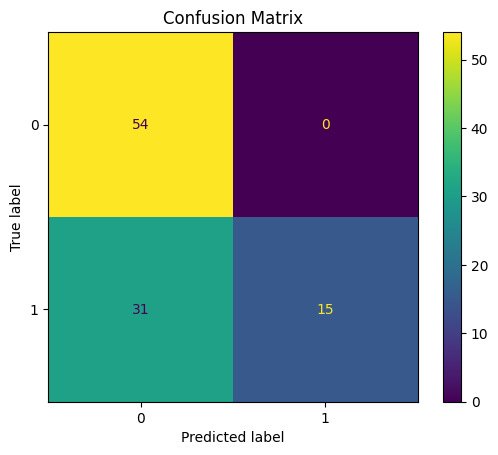

In [12]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(5, 5))
disp.plot(values_format='d')
plt.title("Confusion Matrix")
plt.show()

Showing: /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/good_weld_vid1098_jpeg.rf.fa02bd1ec37898d82bf990525548da93.jpg
Description: The weld exhibits significant surface imperfections, including excessive spatter, irregular bead shape, and potential undercut or incomplete fusion. Visible porosity is also suggested by the uneven texture of the weld bead.


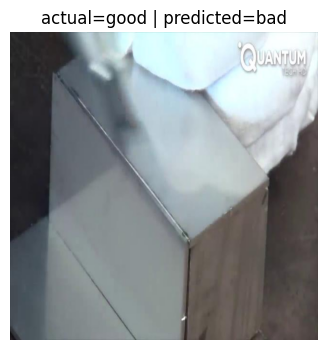


Showing: /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/good_weld_vid505_jpeg_jpg.rf.45b33c7999793e28cfd56029c6f5d0fd.jpg
Description: The weld exhibits significant surface irregularities, signs of poor fusion, and what appears to be slag inclusions or burn-through, indicative of a structurally unsound and unacceptable weld according to ISO 5817 standards.


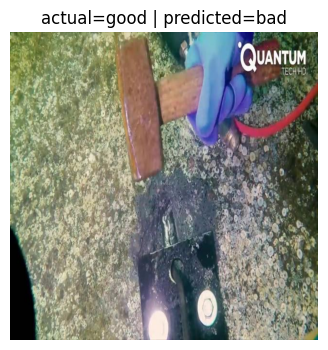


Showing: /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/good-stick-welds_21_jpeg.rf.efbb03ebea526cb3b14ebf8607957933.jpg
Description: The weld exhibits several visible defects including numerous porosity holes, inconsistent bead width, and a lack of uniform surface texture, indicating poor quality.


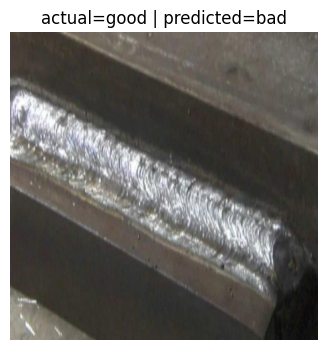


Showing: /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/good-stick-welds_38_jpeg_jpg.rf.a798a6f14879da205dac297a653d167f.jpg
Description: The weld exhibits significant surface porosity, irregular bead shape, and indications of incomplete fusion or lack of penetration, making it unacceptable by ISO 5817 standards.


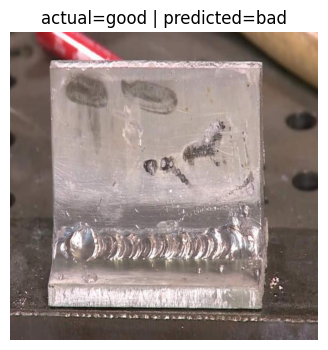


Showing: /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/Good-Welding-images_30_jpeg.rf.4af312f6d3af2b9ec3a3c7814019f387.jpg
Description: The weld exhibits excessive spatter, irregular bead shape, and likely incomplete fusion and penetration due to the presence of rust and poor surface preparation on the base material.


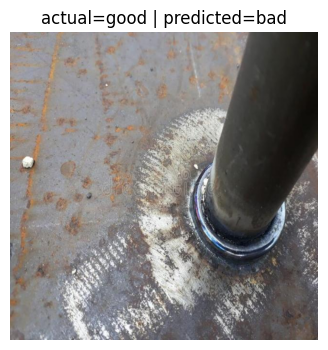


Showing: /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/good_weld_vid1524_jpeg_jpg.rf.923ca28d540ddd883e105a445dfff8a3.jpg
Description: The weld exhibits excessive reinforcement and an irregular bead shape. Visible discoloration suggests potential for inconsistent heat input. The text indicates a wide gap was filled with material, implying a deviation from ideal joint preparation, which can lead to quality issues.


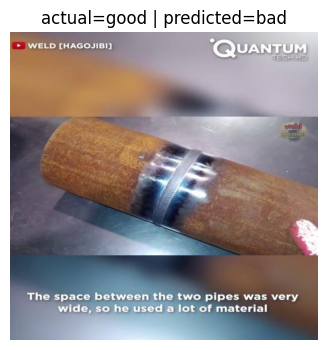


Showing: /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/SampleV2_2_mp4-76_jpg.rf.492360f34b458a190c41d157fff3dbba.jpg
Description: The weld exhibits multiple visible defects including porosity holes, inconsistent bead width and height, and possible undercut along the edges, indicating poor fusion and insufficient quality according to ISO 5817 standards.


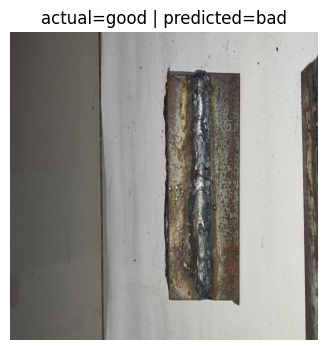


Showing: /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/good-stick-welds_36_jpeg.rf.f82337b4f1f0b3b21e15819eb6298549.jpg
Description: The weld exhibits numerous surface imperfections including porosity, inconsistent bead width, and potential lack of fusion between passes.


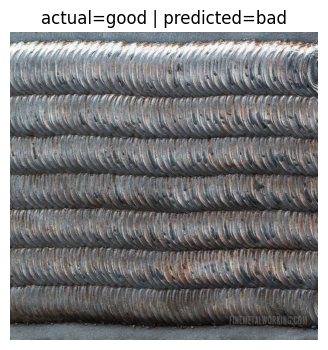


Showing: /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/bad_weld_vid397_jpeg_jpg.rf.6aacbe170c5956e56b1024f24d60c60c.jpg
Description: The weld exhibits significant porosity, irregular bead shape, excessive spatter, and what appears to be incomplete fusion or slag inclusions, indicating poor weld quality.


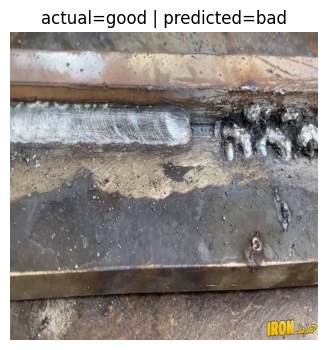


Showing: /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/good_weld_vid1762_jpeg.rf.92508865967a0204f5b78457d8131ac6.jpg
Description: The weld exhibits numerous visible defects including significant porosity (small holes) along the bead, likely indicating poor gas shielding or contamination. There also appears to be evidence of undercut and inconsistent bead width and height, suggesting a lack of proper fusion and control. Excessive spatter is also present. These issues collectively indicate a poor-quality weld that is not structurally sound and does not meet typical industrial standards or ISO 5817 requirements for acceptable imperfections.


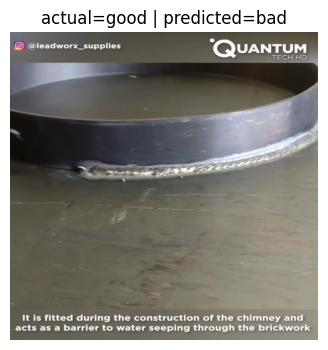


Showing: /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/Good-Welding-images_28_png.rf.503eeed161b61cf8ec218b1c17440787.jpg
Description: Visible porosity, irregular bead shape, and indications of undercut are present, failing to meet ISO 5817 criteria for acceptable weld imperfections.


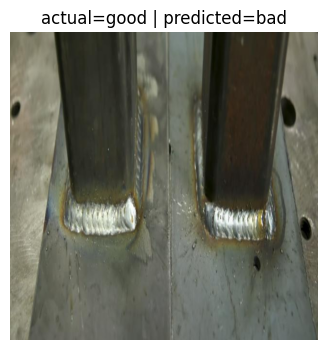


Showing: /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/bad_weld_vid280_jpeg.rf.84ae852be0cfdf652d6c54a8ea04b4f9.jpg
Description: The weld exhibits severe defects including significant porosity, irregular bead shape, undercut, and potential lack of fusion, rendering it structurally unsound.


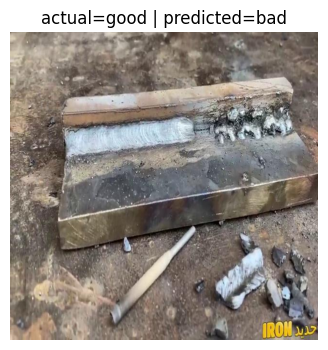


Showing: /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/good-tig-welds_49_jpeg.rf.0a42f6bb041a139dc54f82c007c91b66.jpg
Description: The weld exhibits significant porosity, inconsistent bead shape, irregular penetration, and visible signs of undercut, failing to meet basic quality standards.


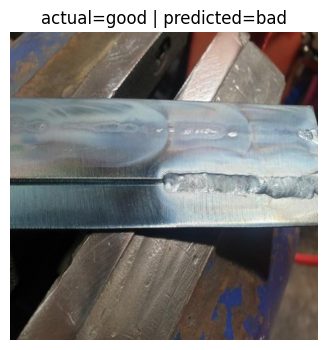


Showing: /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/Screenshot-2022-12-05-230149_jpeg.rf.9a609cc50aed07d1532d574bdfddd081.jpg
Description: The weld exhibits significant irregularities in surface uniformity, indicative of incomplete fusion or poor deposition. The bead shape is irregular, and there appears to be evidence of porosity and potential undercut along the edges. The transition from the base metal to the weld is not smooth, suggesting a lack of consistent penetration.


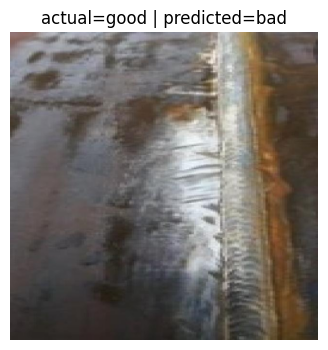


Showing: /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/good_weld_vid1134_jpeg_jpg.rf.5531f5eb2fc03e6b2b992469c012caa4.jpg
Description: The weld displays significant visible defects including porosity, irregular bead shape, and likely poor penetration, indicating a bad weld quality.


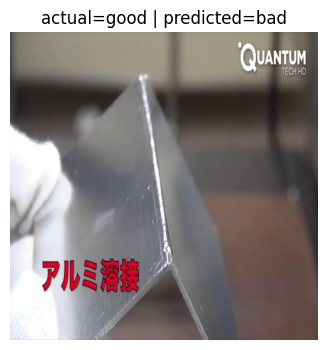


Showing: /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/good_weld_vid863_jpeg_jpg.rf.9e85aba7b2a24a1cd973afa34c9278c0.jpg
Description: The weld exhibits significant defects including excessive spatter, irregular bead shape with inconsistent height and width, and likely poor penetration. There appears to be a lack of uniform fusion and potentially porosity.


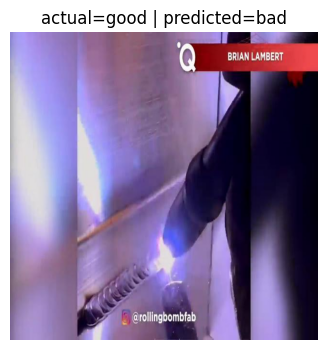


Showing: /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/good_weld_vid414_jpeg_jpg.rf.39639646ba20dd336dd4f880cafd2f7a.jpg
Description: The weld exhibits severe undercut, inconsistent bead width, and likely insufficient penetration, indicating a poor quality weld.


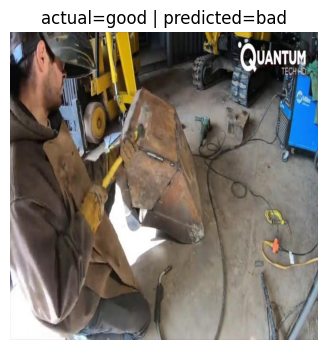


Showing: /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/good-tig-welds_4_jpeg_jpg.rf.3e3a5bbd002257f6e3845eaecef98355.jpg
Description: The weld displays significant porosity, irregular bead shape, and potential undercut along the toes.


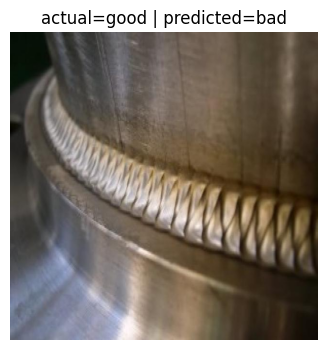


Showing: /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/SampleV3_1_mp4-8_jpg.rf.15adb36ac87bf5e5533ced60df5f5635.jpg
Description: The top weld shows moderate porosity, uneven bead width, and potential for lack of fusion due to inconsistent penetration. The bottom weld exhibits severe undercut, significant porosity, an irregular bead shape, and burn-through at the lower end, indicating a structurally unsound weld.


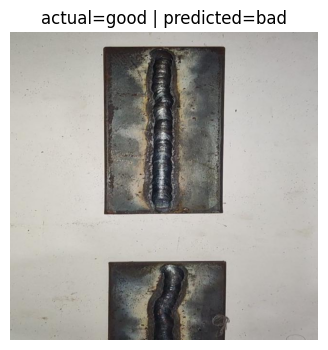


Showing: /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/bad_weld_vid84_jpeg_jpg.rf.f148c4898a835b73a3eb087d905ed8f3.jpg
Description: The weld exhibits significant porosity, irregular bead shape, and indications of inconsistent penetration and lack of fusion.


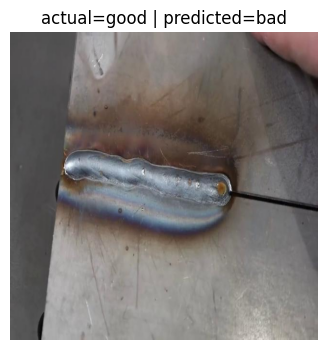


Showing: /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/good_weld_vid189_jpeg_jpg.rf.33380af68fa3c4f459a81f26d1bdbcb9.jpg
Description: The weld exhibits significant porosity on the base metal, excessive spatter, and potential undercut along the edges, indicating poor weld quality according to ISO 5817.


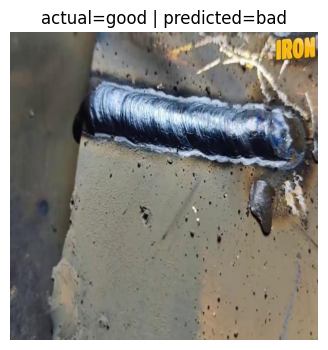


Showing: /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/Spatters-welding-images_20_jpeg.rf.a22cf567f9f4a000618175f38dc1b1ee.jpg
Description: Excessive spatter, porosity, and likely incomplete fusion are evident.


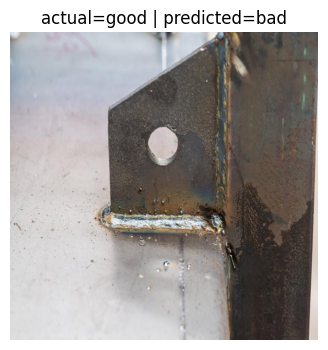


Showing: /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/good-tig-welds_32_png_jpg.rf.31e47557dc8768f6a9dd99627ca3a6e7.jpg
Description: The weld displays visible porosity, an irregular bead shape with inconsistent ripples, and potential undercut along the edges, indicating poor quality and insufficient fusion.


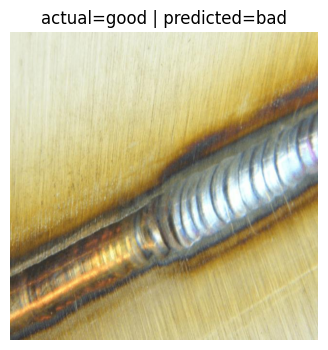


Showing: /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/good_weld_vid104_jpeg_jpg.rf.892dcfa6c4ff7737002a45507ebace2b.jpg
Description: Visible defects include irregular bead shape, excessive spatter, and lack of consistent penetration. The weld exhibits undercut and potential porosity.


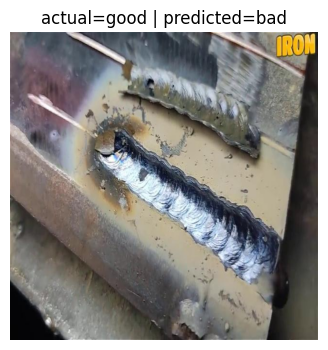


Showing: /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/good_weld_vid634_jpeg_jpg.rf.9b7bc6b6e69b54eb707c9bab8857b7a1.jpg
Description: The weld exhibits excessive spatter and an irregular bead shape, indicating poor surface uniformity and potential issues with penetration consistency. There are visible signs of porosity, and the overall aesthetic suggests it would not meet industrial standards for a structurally sound weld.


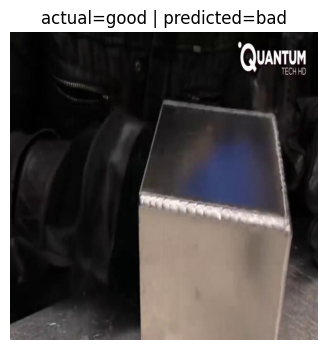


Showing: /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/good_weld_vid1098_jpeg_jpg.rf.9237cce5d77a8a1c3a6dda6c976ca7d5.jpg
Description: The weld exhibits significant porosity, inconsistent bead width and height, and possible undercut, indicating poor fusion and incomplete coverage.


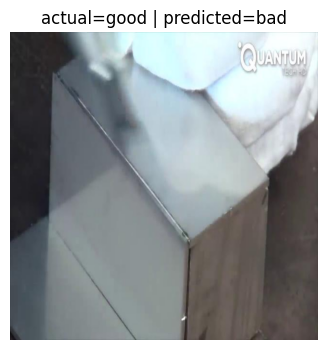


Showing: /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/good_weld_vid469_jpeg.rf.bb8d4104e49f8bd79aef34b7ed48b49f.jpg
Description:  The weld displays significant defects including porosity, inconsistent bead profile, evidence of slag inclusions, and potential lack of fusion.


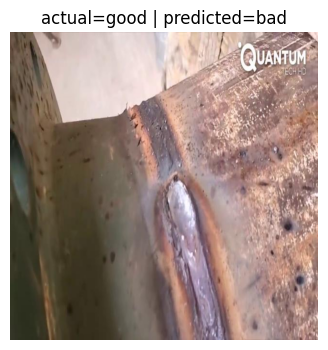


Showing: /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/good_weld_vid274_jpeg.rf.b6f11d0f012275ef3823e747c05bb460.jpg
Description: The weld exhibits numerous surface imperfections including excessive spatter, slag inclusions, potential porosity (indicated by small dark spots on the surface), and irregular bead shape. There are also indications of undercut along the edges of the weld bead. The overall appearance suggests poor fusion and lack of uniformity, likely leading to a structurally unsound weld.


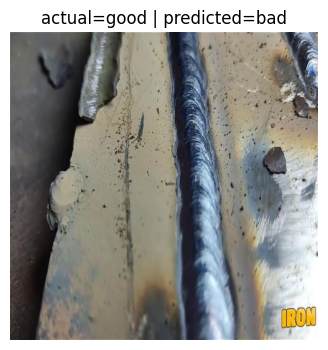


Showing: /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/poor-Welding-Images_22_jpeg_jpg.rf.3706f7e9a367ae053abfee4902a78288.jpg
Description: The "fast" weld exhibits significant undercut along its length, irregular bead shape with excessive spatter, and potential porosity. The "slow" weld also displays excessive spatter and an irregular bead with undercut at the edges. The "OK" weld appears the best of the three, showing good surface uniformity and minimal visible defects, suggesting it meets quality criteria. However, the overall image showcases multiple "bad" welds.


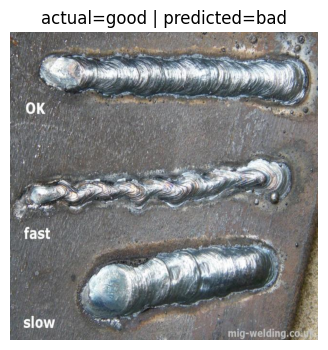


Showing: /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/good_weld_vid1199_jpeg.rf.9d57a01453bae20900fa6b90909f299b.jpg
Description: The weld exhibits significant porosity, irregular bead shape, and possible undercut, indicating poor fusion and a lack of structural integrity according to ISO 5817.


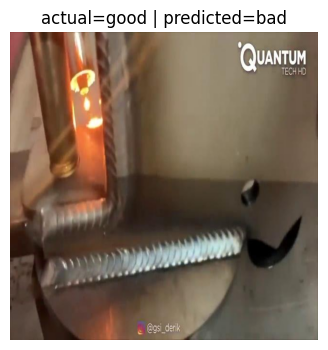


Showing: /kaggle/input/welding-defect-object-detection/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/good_weld_vid100_jpeg.rf.8119452a868f43e546f35a5c98975194.jpg
Description: The weld exhibits significant porosity, uneven bead shape, and possible undercut, indicating poor fusion and lack of penetration, which are critical defects according to ISO 5817.


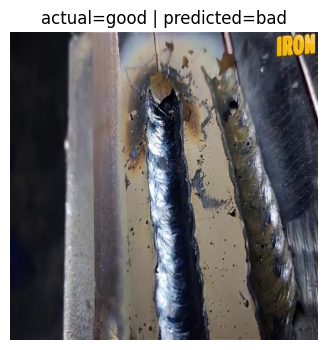

In [13]:
wrong = df[df["actual"] != df["predicted"]]

for _, row in wrong.iterrows():
    img_path = row["filename"]
    print(f"Showing: {img_path}")
    print(f"Description: {row['description']}")

    img = Image.open(img_path)
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"actual={'good' if row['actual']==1 else 'bad'} | predicted={'good' if row['predicted']==1 else 'bad'}")
    plt.show()
    print()

## Gradio Application

In [14]:
custom_css = """
.gradio-container {
    padding-left: 15% !important;
    padding-right: 15% !important;
}
"""

In [15]:
def analyzer_handler(image_input, selected_model_name, prompt_input):
    prediction, description = analyze_weld_image(image_input, prompt_input, selected_model_name)
    answer = f"""### That is a {'good' if prediction==1 else 'bad'} weld!<br>Reason: {description}"""
    return (
        gr.update(visible=False),     # dont show dropdown
        gr.update(visible=False),     # dont show prompt
        gr.update(visible=False),     # dont show analyze button
        gr.update(value=answer),      # show answer text
        gr.update(visible=True)       # show new analysis button
    )

def reset_state():
    return (
        gr.update(value=None),        # remove image from cache
        gr.update(visible=True),      # show dropdown
        gr.update(visible=True),      # show prompt
        gr.update(visible=True),      # show analyze button
        gr.update(value=""),          # remove answer from cache
        gr.update(visible=False)      # dont show new analysis button
    )

In [ ]:
with gr.Blocks(theme='Nymbo/Nymbo_Theme', css=custom_css, title='Weld Image Analysis') as weld_app:
    gr.Markdown("""
        # Weld Image Analysis
        ## by Group 3
        <br>
    """)

    # List of available Gemini models for the dropdown
    # https://ai.google.dev/gemini-api/docs/models
    gemini_models = [
        'gemini-pro-latest',
        'gemini-flash-latest',
        'gemini-flash-lite-latest'
    ]

    image_input = gr.Image(type='pil', label="Upload Weld Image")

    model_selector = gr.Dropdown(
        choices=gemini_models,
        label="Select Gemini Model",
        value=gemini_models[1]
    )

    prompt_input = gr.Textbox(
        label="Adjust Prompt",
        value=WELD_PROMPT,
        html_attributes=InputHTMLAttributes(spellcheck=False)
    )

    analyze_button = gr.Button("Analyze Weld")
    output_text = gr.Markdown("")
    new_button = gr.Button("Start New Analysis", visible=False)


    # Call analyze_weld_image() function
    analyze_button.click(
        fn=analyzer_handler,
        inputs=[image_input, model_selector, prompt_input],
        outputs=[model_selector, prompt_input, analyze_button, output_text, new_button]
    )

    # Call reset_state() function
    new_button.click(
        reset_state,
        outputs=[image_input, model_selector, prompt_input, analyze_button, output_text, new_button]
    )

weld_app.launch(share=True, inline=False, favicon_path='/content/favicon.png', debug=True)

/tmp/ipython-input-2933910133.py:1: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme='Nymbo/Nymbo_Theme', css=custom_css, title='Weld Image Analysis') as weld_app:
/tmp/ipython-input-2933910133.py:1: DeprecationWarning: The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.
  with gr.Blocks(theme='Nymbo/Nymbo_Theme', css=custom_css, title='Weld Image Analysis') as weld_app:


theme_schema%400.0.1.json: 0.00B [00:00, ?B/s]

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://00524df93d72438584.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
